# Set Up

## Loading Libraries

In [4]:
# linear algebra
import numpy as np 
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 

# data check
from collections import Counter

# transformer
import torch
from transformers import BertModel, BertTokenizer
import datasets

# analysis
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# use biopython to extract protein properties
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# util
from tqdm import tqdm

# Input data files are available in the read-only "/input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Load Model

### ProtBert model is being loaded from Rosatlab which is a pretrained model on protien sequence. This model can be used for feature extraction as well as for fine tuning.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert").to(device)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Data Preparation

## Load Data

In [6]:
train = pd.read_csv('input/novozymes-enzyme-stability-prediction/train.csv')
train_update = pd.read_csv('input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv',
                           index_col='seq_id')
#Dropping "data_source" column as it has no data
train_update = train_update.drop('data_source', axis = 1)
test = pd.read_csv('input/novozymes-enzyme-stability-prediction/test.csv')

## Data Correction

In [7]:
train_drop_id = train_update[train_update.isnull().all('columns')].index
train_swap_id = train_update[train_update.notnull().all('columns')].index

train = train.drop(train.index[train_drop_id], axis = 0)
train.loc[train_swap_id, ['pH','tm']] = train_update.loc[train_swap_id, ['pH','tm']]
train = train.reset_index(drop = True)

## Checking Input Sequence Length

In [8]:
train['seq_length'] = [len(s) for s in train['protein_sequence']]
print(f"MIN :{train['seq_length'].min()}\nMAX :{train['seq_length'].max()}\n\
MEAN :{train['seq_length'].mean()}\nMEDIAN :{train['seq_length'].median()}")

MIN :5
MAX :8798
MEAN :450.468617370001
MEDIAN :351.0


## Drop too long sequences

In [9]:
train['seq_length'].quantile(0.90)

851.0

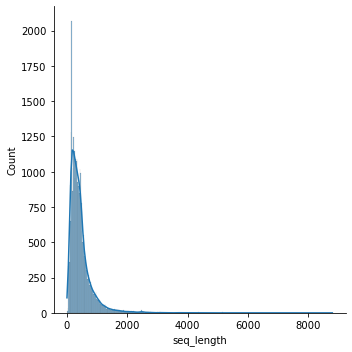

In [10]:
sns.displot(train['seq_length'],kde=True)

In [11]:
# drop too long sequence
train_long_id = train[train['seq_length']>851].index
train = train.drop(train.index[train_long_id], axis = 0)
train = train.reset_index(drop = True)

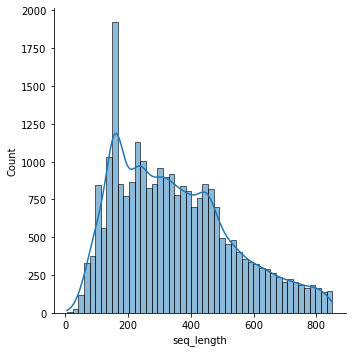

In [12]:
sns.displot(train['seq_length'],kde=True)

#### We are dropping sequences that are too long to save the GPU memory, as from the above plots you can observe that most of the sequence has length between 200 and 850.

# Test Prot_Bert

## Tokenize sequences

### Test by single sequence

In [13]:
sequence_example = train['protein_sequence'][4]
sequence_example = ' '.join(list(sequence_example))
encoded_input = tokenizer(sequence_example, return_tensors='pt').to(device)
output = model(**encoded_input)

In [14]:
encoded_input['input_ids'].shape

torch.Size([1, 382])

In [15]:
output['last_hidden_state'].shape

torch.Size([1, 382, 1024])

In [16]:
output['last_hidden_state'][:,0][0].detach().cpu().numpy()

array([ 0.05609831,  0.01732929,  0.03116154, ...,  0.03675359,
       -0.00251826, -0.03068385], dtype=float32)

In [17]:
len(output['last_hidden_state'][:,0][0].detach().cpu().numpy())

1024

#### The tokenizer of prot_bert only accept white space splitted sequence. So added spaces before processing the sequence.

## Batch encoding and extract last hidden state

In [18]:
def tokenize(batch):
    return tokenizer(batch['text'], padding = True, truncation = True)

def extract_hidden_state(batch):
    inputs = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_state':last_hidden_state[:,0].cpu().numpy()}

In [19]:
train['text'] = [' '.join(list(s)) for s in train['protein_sequence']]
train_dataset = datasets.Dataset.from_pandas(train[['text', 'tm']])

# UMAP to dimension reduction

## Load Embeddings 

In [21]:
train_hidden_df = pd.read_csv('input/hidden-state-of-train-for-novoenzyme-by-protbert/train_hidden_df.csv')

In [23]:
train_hidden_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.114555,0.148582,0.135553,-0.166893,0.041747,-0.027344,-0.091174,-0.004800,-0.050336,-0.079362,...,-0.080400,0.003139,0.023127,-0.102654,-0.040916,0.018848,0.119827,0.049316,-0.082001,-0.119446
1,0.002285,0.038957,0.150450,-0.205247,0.106029,-0.039785,-0.051584,0.144215,0.039499,-0.076444,...,-0.052897,-0.026156,-0.074305,-0.191335,-0.030166,-0.110571,0.018213,0.012143,-0.045633,-0.047796
2,0.054213,0.056445,0.082515,-0.124347,0.135242,-0.035300,-0.102356,0.072578,-0.010810,-0.022213,...,0.008368,0.000739,-0.050074,-0.132745,-0.009848,-0.081265,-0.040665,-0.035884,-0.039222,-0.038160
3,-0.048199,0.005975,0.102868,-0.200675,0.052536,0.031037,-0.076462,0.084789,0.025286,-0.079598,...,0.048855,-0.000485,-0.121472,-0.102972,0.000671,-0.040275,-0.042424,0.043839,0.005652,0.068146
4,0.056098,0.017330,0.031161,-0.096948,0.147974,-0.041948,-0.121821,0.028237,-0.002102,-0.076520,...,-0.009591,0.021224,-0.048682,-0.148638,-0.041934,-0.097662,-0.025656,0.036753,-0.002518,-0.030684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26082,0.138387,0.052255,0.079374,-0.133288,0.224996,-0.013203,-0.124030,0.011948,-0.069751,-0.143219,...,-0.206538,0.050404,-0.116736,-0.051876,-0.068218,-0.139211,-0.067432,-0.109106,-0.028020,-0.009090
26083,0.067325,0.134365,0.049602,-0.125076,0.263882,-0.052299,-0.153537,0.043827,-0.005980,-0.096870,...,-0.123479,0.047480,-0.040308,-0.071183,-0.004105,-0.088179,0.015809,-0.015285,0.016282,-0.033346
26084,-0.100930,0.255186,0.269644,-0.244223,0.198940,-0.074295,-0.195742,0.144530,0.156142,0.015718,...,-0.122622,-0.095689,-0.007173,-0.025496,-0.166613,-0.155954,-0.033490,0.058065,-0.055840,-0.072954
26085,0.156727,0.080463,0.094867,-0.152492,0.222330,-0.021805,-0.127559,0.028244,-0.043550,-0.140213,...,-0.200901,0.052287,-0.121591,-0.069596,-0.058714,-0.142392,-0.058007,-0.106008,-0.027094,-0.007159


## Scaling and UMAP fitting

In [24]:
# scaling by MinMaxScaler
train_hidden_scaled = MinMaxScaler().fit_transform(train_hidden_df)
mapper = UMAP(n_components = 2, metric = 'cosine', random_state = 0).fit(train_hidden_scaled)

## Visualize UMAP results

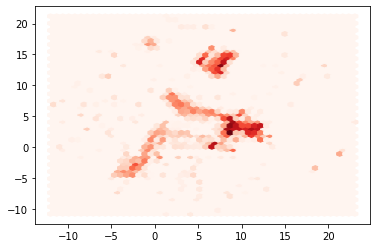

/Users/phanithdsv/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


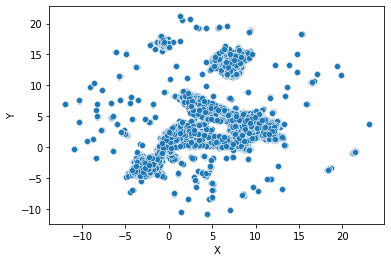

In [25]:
embeddin_pos = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])

plt.hexbin(embeddin_pos.X, embeddin_pos.Y, cmap='Reds', gridsize=50)
plt.show()

sns.scatterplot(embeddin_pos.X, embeddin_pos.Y)
plt.show()

## Clustering by several methods using results of UMAP

In [27]:
#Ploting function used to plot for different clustering methods
def show_plots(clusters):
    sns.scatterplot(embeddin_pos.X, embeddin_pos.Y, hue=clusters)
    plt.show()

    train_tm = pd.DataFrame({'tm':train['tm'], 'clusters':clusters})
    
    sns.displot(data=train, x='tm', hue=clusters, kde=True, height=6, aspect=2)
    plt.xlim([0,125])
    plt.show()

## K-Means Clustering

/Users/phanithdsv/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


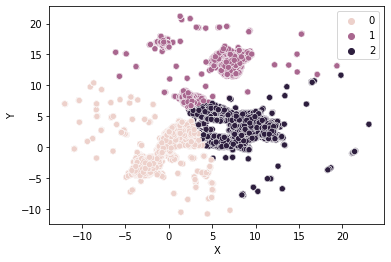

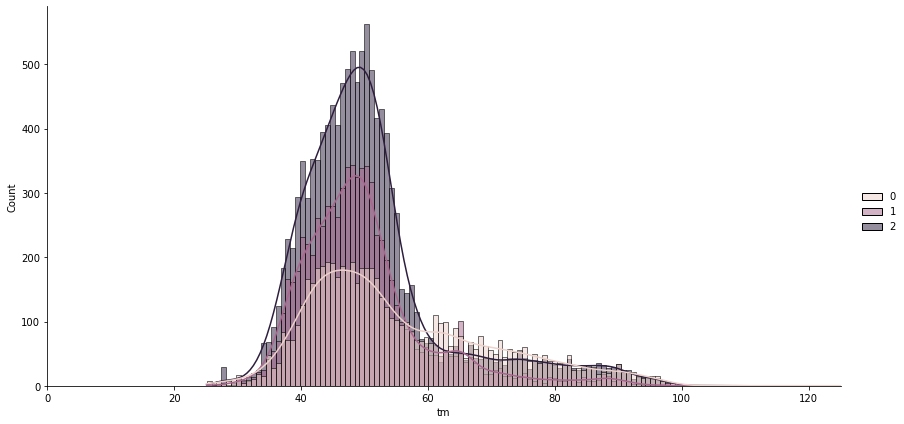

In [28]:
#Keeping the number of clusters to 3
model = KMeans(n_clusters=3, random_state=0)

model.fit(embeddin_pos)
clusters_kmeans = model.predict(embeddin_pos)

show_plots(clusters_kmeans)

## Gaussian mixture

/Users/phanithdsv/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


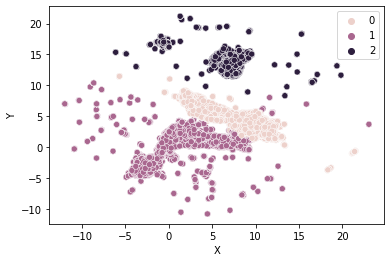

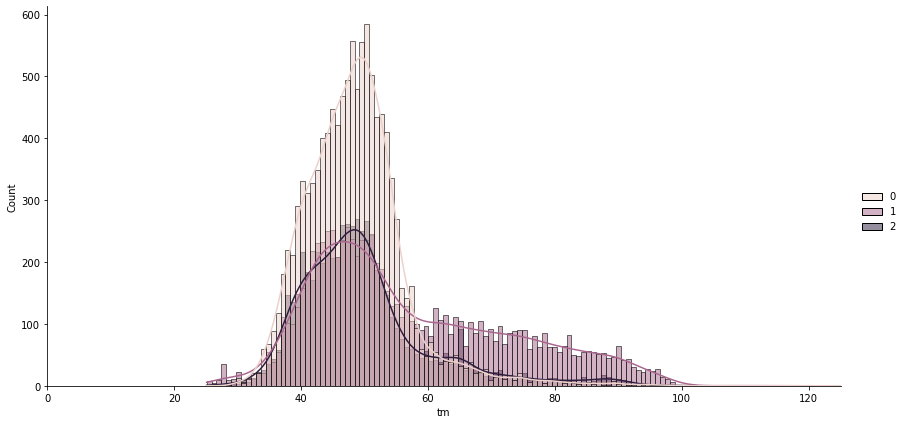

In [29]:
model = GaussianMixture(n_components=3)
model.fit(embeddin_pos)
clusters_gaussian = model.predict(embeddin_pos)

show_plots(clusters_gaussian)

##### Well clustered!!
##### Cluster 2 has more enzymes with high tm than cluster 0 and 1.
##### It needs to explore properties of enzymes in cluster 2.